In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from IPython import display
import math
from sklearn.preprocessing import StandardScaler

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Multi_core/dataset_s.csv')
# data = pd.read_csv('../data/prepocessed_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dropped_col = ['s']

In [ ]:
data.head()

,time,cpu-cycles,dTLB-load-misses,s
0,0.170,5042954127,890791,0.02
1,0.096,4340093839,691644,0.02
2,0.072,4982218435,906193,0.02
3,0.060,4535489921,817096,0.02
4,0.053,4951607442,962960,0.02


In [ ]:
X = data.drop(dropped_col, axis=1)
y = data[dropped_col]

In [ ]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
# train test split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [ ]:
X_train_tensor = torch.from_numpy(X_train.values)
y_train_tensor = torch.from_numpy(y_train.values)
X_val_tensor = torch.from_numpy(X_val.values)
y_val_tensor = torch.from_numpy(y_val.values)
X_test_tensor = torch.from_numpy(X_test.values)
y_test_tensor = torch.from_numpy(y_test.values)

In [ ]:
print("X_train_Size: " + str(X_train_tensor.shape))
print("y_train_Size: " + str(y_train_tensor.shape))
print("X_val_Size: " + str(X_val_tensor.shape))
print("y_val_Size: " + str(y_val_tensor.shape))
print("X_test: " + str(X_test_tensor.shape))
print("y_test_Size: " + str(y_test_tensor.shape))

X_train_Size: torch.Size([6804, 3])
y_train_Size: torch.Size([6804, 1])
X_val_Size: torch.Size([1458, 3])
y_val_Size: torch.Size([1458, 1])
X_test: torch.Size([1459, 3])
y_test_Size: torch.Size([1459, 1])


In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
I = 3  # input feature
O = 1 # output result
H = 64 # hidden unit
H_half = 16

In [ ]:
model = nn.Sequential(
    nn.Linear(I, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, O)
)
model = model.to(torch.float64)

In [ ]:
weight_tensor = model[0].weight

# Get the datatype of the weight tensor
weight_tensor.dtype

torch.float64

In [ ]:
X_train_tensor.dtype

torch.float64

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, loader, optimizer):
    loss_sum = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        optimizer.zero_grad()
        output = model(inputs)
        loss = torch.nn.functional.mse_loss(output, targets)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        
    avg_loss = loss_sum / len(loader)
    print(f"Train MSE loss: {avg_loss:.4f}")
    return avg_loss

In [ ]:
train_losses = []
train_rmses = []
train_maes = []
val_losses = []
val_rmses = []
val_maes = []

In [ ]:
#train
for epoch in range(2000):
    print(f"Epoch {epoch + 1}")
    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    with torch.no_grad():
        mae_sum = 0.0
        rmse_sum = 0.0
        total = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            output = model(inputs)
            mae_sum += torch.abs(output - targets).sum().item()
            rmse_sum += torch.square(output - targets).sum().item()
            total += len(targets)
        mae = mae_sum / total
        rmse = math.sqrt(rmse_sum / total)
        train_rmses.append(rmse)
        train_maes.append(mae)
        print(f"Train MSE: {train_loss:.4f}, Train MAE: {mae:.4f}, Train RMSE: {rmse:.4f}")
    
    # validation
    with torch.no_grad():
        loss_sum = 0.0
        val_mae_sum = 0.0
        val_rmse_sum = 0.0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            output = model(inputs)
            loss = torch.nn.functional.mse_loss(output, targets)
            loss_sum += loss.item()
            val_mae_sum += torch.abs(output - targets).sum().item()
            val_rmse_sum += torch.square(output - targets).sum().item()
            total += len(targets)

        avg_loss = loss_sum / len(test_loader)
        val_losses.append(avg_loss)
        val_mae = val_mae_sum / total
        val_rmse = math.sqrt(val_rmse_sum / total)
        val_rmses.append(val_rmse)
        val_maes.append(val_mae)
        print(f"Test MSE: {avg_loss:.4f}, Test MAE: {val_mae:.4f}, Test RMSE: {val_rmse:.4f}")
    # display.clear_output(wait=True)

Streaming output truncated to the last 5000 lines.
Epoch 751
Train MSE loss: 0.0198
Train MSE: 0.0198, Train MAE: 0.0811, Train RMSE: 0.1372
Test MSE: 0.0253, Test MAE: 0.0899, Test RMSE: 0.1592
Epoch 752
Train MSE loss: 0.0195
Train MSE: 0.0195, Train MAE: 0.0834, Train RMSE: 0.1425
Test MSE: 0.0267, Test MAE: 0.0932, Test RMSE: 0.1640
Epoch 753
Train MSE loss: 0.0203
Train MSE: 0.0203, Train MAE: 0.0813, Train RMSE: 0.1457
Test MSE: 0.0296, Test MAE: 0.0914, Test RMSE: 0.1727
Epoch 754
Train MSE loss: 0.0197
Train MSE: 0.0197, Train MAE: 0.0772, Train RMSE: 0.1365
Test MSE: 0.0258, Test MAE: 0.0871, Test RMSE: 0.1613
Epoch 755
Train MSE loss: 0.0199
Train MSE: 0.0199, Train MAE: 0.0861, Train RMSE: 0.1433
Test MSE: 0.0265, Test MAE: 0.0941, Test RMSE: 0.1637
Epoch 756
Train MSE loss: 0.0201
Train MSE: 0.0201, Train MAE: 0.0767, Train RMSE: 0.1369
Test MSE: 0.0262, Test MAE: 0.0874, Test RMSE: 0.1608
Epoch 757
Train MSE loss: 0.0200
Train MSE: 0.0200, Train MAE: 0.0796, Train RMSE: 0.

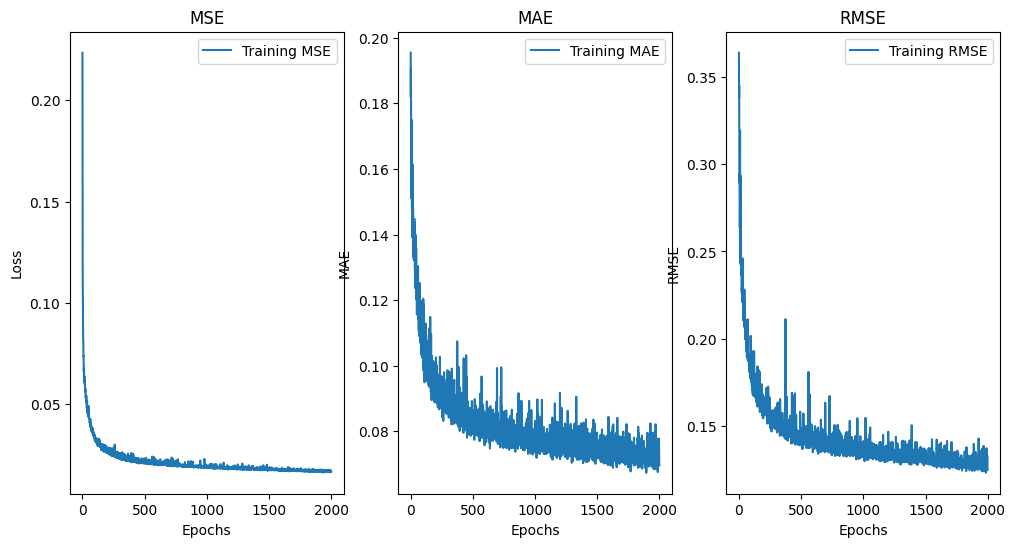

In [ ]:
# train loss, mae, rmse
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# plot the MSE values
ax1.plot(train_losses, label='Training MSE')
ax1.set_title('MSE')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the MAE values
ax2.plot(train_maes, label='Training MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

# plot the RMSE values
ax3.plot(train_rmses, label='Training RMSE')
ax3.set_title('RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.legend()

# show the plot
plt.show()

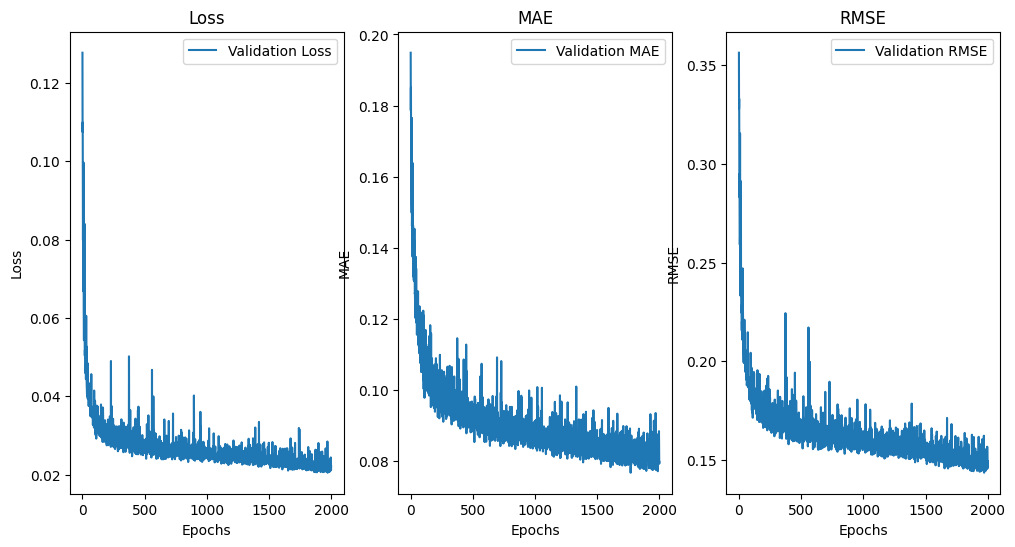

In [ ]:
# val loss, accuracy
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# plot the MSE values
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the MAE values
ax2.plot(val_maes, label='Validation MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

# plot the RMSE values
ax3.plot(val_rmses, label='Validation RMSE')
ax3.set_title('RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.legend()

# show the plot
plt.show()

In [ ]:
with torch.no_grad():
      loss_sum = 0.0
      val_mae_sum = 0.0
      val_rmse_sum = 0.0
      total = 0
      for batch_idx, (inputs, targets) in enumerate(test_loader):
          output = model(inputs)
          loss = torch.nn.functional.mse_loss(output, targets)
          loss_sum += loss.item()
          val_mae_sum += torch.abs(output - targets).sum().item()
          val_rmse_sum += torch.square(output - targets).sum().item()
          total += len(targets)

      avg_loss = loss_sum / len(test_loader)
      val_losses.append(avg_loss)
      val_mae = val_mae_sum / total
      val_rmse = math.sqrt(val_rmse_sum / total)
      val_rmses.append(val_rmse)
      val_maes.append(val_mae)
      print(f"Test MSE: {avg_loss:.4f}, Test MAE: {val_mae:.4f}, Test RMSE: {val_rmse:.4f}")

Test MSE: 0.0195, Test MAE: 0.0765, Test RMSE: 0.1400


In [ ]:
with torch.no_grad():
  y_pred = model(X_test_tensor).detach().numpy()

In [ ]:
y_pred.reshape(-1)

array([-0.13742795,  0.16196026,  0.01770083, ...,  0.04028727,
        0.20424256,  0.88332071])

In [ ]:
y_test.values.reshape(-1)

array([0.03, 0.28, 0.02, ..., 0.02, 0.12, 0.77])

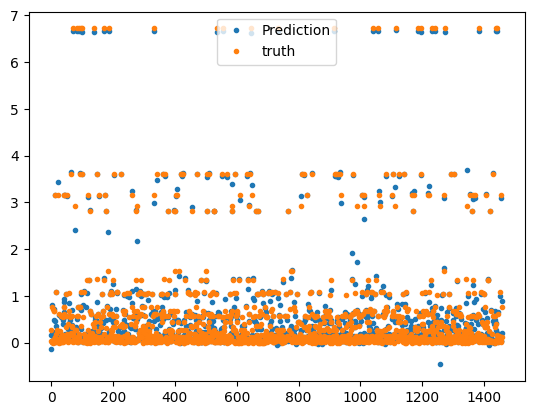

In [ ]:
plt.plot(np.array([i for i in range(len(y_pred))]), y_pred.reshape(-1), '.', label="Prediction")
plt.plot(np.array([i for i in range(len(y_pred))]), y_test.values.reshape(-1), '.', label="truth")
plt.legend()
plt.show()

In [28]:
# Calculate MAE
mae = mean_absolute_error(y_test.values.reshape(-1), y_pred)
print("MAE:", mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.values.reshape(-1), y_pred))
print("RMSE:", rmse)

MAE: 0.0765299923244114
RMSE: 0.14000845229253012


In [29]:
pd.DataFrame(model(torch.from_numpy(X.to_numpy())).detach().numpy()).to_csv('/content/drive/My Drive/Multi_core/s_y.csv')

In [ ]:
model_path = '/content/drive/My Drive/Multi_core/SNet.pt'
torch.save(model, model_path)